In [1]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import pandas as pd
import numpy as np
import json
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

plt.style.use("ggplot")
FIGSIZE = (13, 8)
DPI = 300

In [2]:
from cyvcf2 import VCF
from typing import NamedTuple, Optional, List

In [3]:
class Genotype(NamedTuple):
    allele1: int
    allele2: int

    def is_null(self) -> bool:
        """Is the genotype null. i.e. ./."""
        return self.allele1 == -1 and self.allele2 == -1

    def is_hom(self) -> bool:
        """Is the genotype homozygous"""
        if self.is_null():
            return False
        if self.allele1 == -1 or self.allele2 == -1:
            return True
        return self.allele1 == self.allele2

    def is_het(self) -> bool:
        """Is the genotype heterozyhous"""
        return not self.is_null() and not self.is_hom()

    def is_hom_ref(self) -> bool:
        """Is genotype homozygous reference?"""
        return self.is_hom() and (self.allele1 == 0 or self.allele2 == 0)

    def is_hom_alt(self) -> bool:
        """Is genotype homozygous alternate?"""
        return self.is_hom() and (self.allele1 > 0 or self.allele2 > 0)

    def alt_index(self) -> Optional[int]:
        """If the genotype is homozygous alternate, returns the 0-based index of the
        alt allele in the alternate allele array.
        """
        if not self.is_hom_alt():
            return None
        return max(self.allele1, self.allele2) - 1

    def allele_index(self) -> Optional[int]:
        """The index of the called allele"""
        if self.is_hom_ref() or self.is_null():
            return 0
        elif self.is_hom_alt():
            return self.alt_index() + 1
        else:
            raise NotImplementedError(f"Het Genotype is unexpected: {self}")

    @staticmethod
    def from_arr(arr: List[int]) -> "Genotype":
        alleles = [a for a in arr if type(a) is int]
        if len(alleles) < 2:
            alleles.append(-1)
        return Genotype(*alleles)
    
def is_indel(v):
    empty_alt = not bool(v.ALT)
    gt = Genotype.from_arr(v.genotypes[0])
    if not gt.is_hom_alt():
        return False
    
    rlen = len(v.REF)
    return rlen != len(v.ALT[gt.alt_index()])

In [4]:
valid_clfs = {"FP", "TP", "FN"}
def get_classifications_for_vcf(p, skip_indels=False):
    data = []
    for var in VCF(p):
        truth_clf, query_clf = var.format("BD")
        vartypes = var.format("BVT")
        if skip_indels and "INDEL" in vartypes:
            continue
        if truth_clf == query_clf and truth_clf in valid_clfs:
            data.append((var.CHROM, truth_clf, 1))
            continue
        if truth_clf in valid_clfs:
            data.append((var.CHROM, truth_clf, 1))
        if query_clf in valid_clfs:
            data.append((var.CHROM, query_clf, 1))
    return pd.DataFrame(data, columns=["gene", "classification", "count"])

In [5]:
expected_sample_tech_pairs = {(p.parts[-2], p.parts[-4]) for p in Path("../../results/novel/assessment/").rglob("*.summary.csv")}

In [6]:
bcf_files = list(Path("../../results/novel/assessment/").rglob("*.bcf"))

In [7]:
seen_pairs = set()
skip_indels = True
classification_dfs = []
for p in bcf_files:
    d = get_classifications_for_vcf(p, skip_indels=skip_indels)
    sample = p.parts[-2]
    tech = p.parts[-4]
    d["sample"] = sample
    d["tech"] = tech
    classification_dfs.append(d)
    seen_pairs.add((sample, tech))

In [8]:
missing_pairs = expected_sample_tech_pairs - seen_pairs
missing_pairs

{('18_0622312', 'illumina'),
 ('18_0622312', 'nanopore'),
 ('R23571', 'illumina'),
 ('R23571', 'nanopore'),
 ('mada_1-15', 'illumina'),
 ('mada_1-15', 'nanopore'),
 ('mada_1-2', 'illumina'),
 ('mada_1-2', 'nanopore'),
 ('mada_1-25', 'illumina'),
 ('mada_106', 'illumina'),
 ('mada_106', 'nanopore'),
 ('mada_109', 'illumina'),
 ('mada_109', 'nanopore'),
 ('mada_120', 'illumina'),
 ('mada_120', 'nanopore'),
 ('mada_123', 'illumina'),
 ('mada_123', 'nanopore'),
 ('mada_126', 'illumina'),
 ('mada_126', 'nanopore'),
 ('mada_2-25', 'illumina'),
 ('mada_2-25', 'nanopore')}

In [9]:
missing_pair_vcfs = []
for sample, tech in missing_pairs:
    truth = Path(f"../../results/novel/filtered_vcfs/{sample}.trimmed.bcf")
    if sample.startswith("R"):
        site = "south_africa"
    elif sample.startswith("m"):
        site = "madagascar"
    else:
        site = "birmingham"
    query = Path(f"../../results/drprg/filtered_vcfs/{tech}/{site}/{sample}.novel.bcf")
    missing_pair_vcfs.append((truth, query))

In [10]:
for tvcf, qvcf in missing_pair_vcfs:
    data = []
    sample = qvcf.name.split(".")[0]
    tech = qvcf.parts[-3]
    for var in VCF(tvcf):
        if var.FILTER is not None or (skip_indels and is_indel(var)):
            continue
        data.append((var.CHROM, "FN", 1))
    
    for var in VCF(qvcf):
        if var.FILTER is not None or (skip_indels and is_indel(var)):
            continue
        data.append((var.CHROM, "FP", 1))
        
    d = pd.DataFrame(data, columns=["gene", "classification", "count"])
    d["sample"] = sample
    d["tech"] = tech
    classification_dfs.append(d)

In [11]:
df = pd.concat(classification_dfs)

In [12]:
#add a count of 0 for every combination
from itertools import product
empty = []
for g, c, t, s in product(set(df.gene), set(df.classification), set(df.tech), set(df["sample"])):
    row = (g, c, 0, s, t)
    empty.append(row)
    
df = pd.concat([df, pd.DataFrame(empty, columns=["gene", "classification", "count", "sample", "tech"])])

In [13]:
# data = []
# skip_indels = True
# columns = ["sample", "tech", "precision", "recall", "FN", "FP", "TP"]
# for p in summary_files:
#     csv = pd.read_csv(p)
#     sample = p.parts[-2]
#     tech = p.parts[-4]
#     if len(csv.columns) > 3:  # happy output
#         csv.set_index(["Type", "Filter"], inplace=True)
#         tps = csv.loc[("SNP","PASS")]["TRUTH.TP"]
#         fps = csv.loc[("SNP","PASS")]["QUERY.FP"]
#         fns = fps = csv.loc[("SNP","PASS")]["QUERY.FP"]
#     else:  # empty output
#     precision = float(d["Precision"]["Precision_edit_dist"])
#     fps = int(d["Precision"]["FP"]["Count"])
#     recall = float(d["Recall"]["Recall_edit_dist"])
#     fns = int(d["Recall"]["FN"]["Count"])
#     tps = int(d["Recall"]["TP"]["Count"])
#     try:
#         csi = tps/(tps+fps+fns)
#     except ZeroDivisionError:
#         csi=None
#     data.append((sample, tech, precision, recall, fns, fps, tps, csi))
# df = pd.DataFrame(data, columns=columns)

In [14]:
df.query("sample=='mada_1-10' and tech =='nanopore'")

,gene,classification,count,sample,tech
0,ahpC,TP,1,mada_1-10,nanopore
1,embA,TP,1,mada_1-10,nanopore
2,fabG1,TP,1,mada_1-10,nanopore
3,gid,TP,1,mada_1-10,nanopore
4,gid,TP,1,mada_1-10,nanopore
5,gyrA,FN,1,mada_1-10,nanopore
6,katG,TP,1,mada_1-10,nanopore
7,rpoB,TP,1,mada_1-10,nanopore
8,rrs,TP,1,mada_1-10,nanopore
98,katG,FP,0,mada_1-10,nanopore


In [15]:
counts = df.drop(columns=["gene"]).groupby(["sample", "tech", "classification"]).sum().reset_index()
counts

,sample,tech,classification,count
0,17_616026,illumina,FN,0
1,17_616026,illumina,FP,0
2,17_616026,illumina,TP,3
3,17_616026,nanopore,FN,0
4,17_616026,nanopore,FP,0
...,...,...,...,...
829,mada_2-53,illumina,FP,0
830,mada_2-53,illumina,TP,1
831,mada_2-53,nanopore,FN,0
832,mada_2-53,nanopore,FP,0


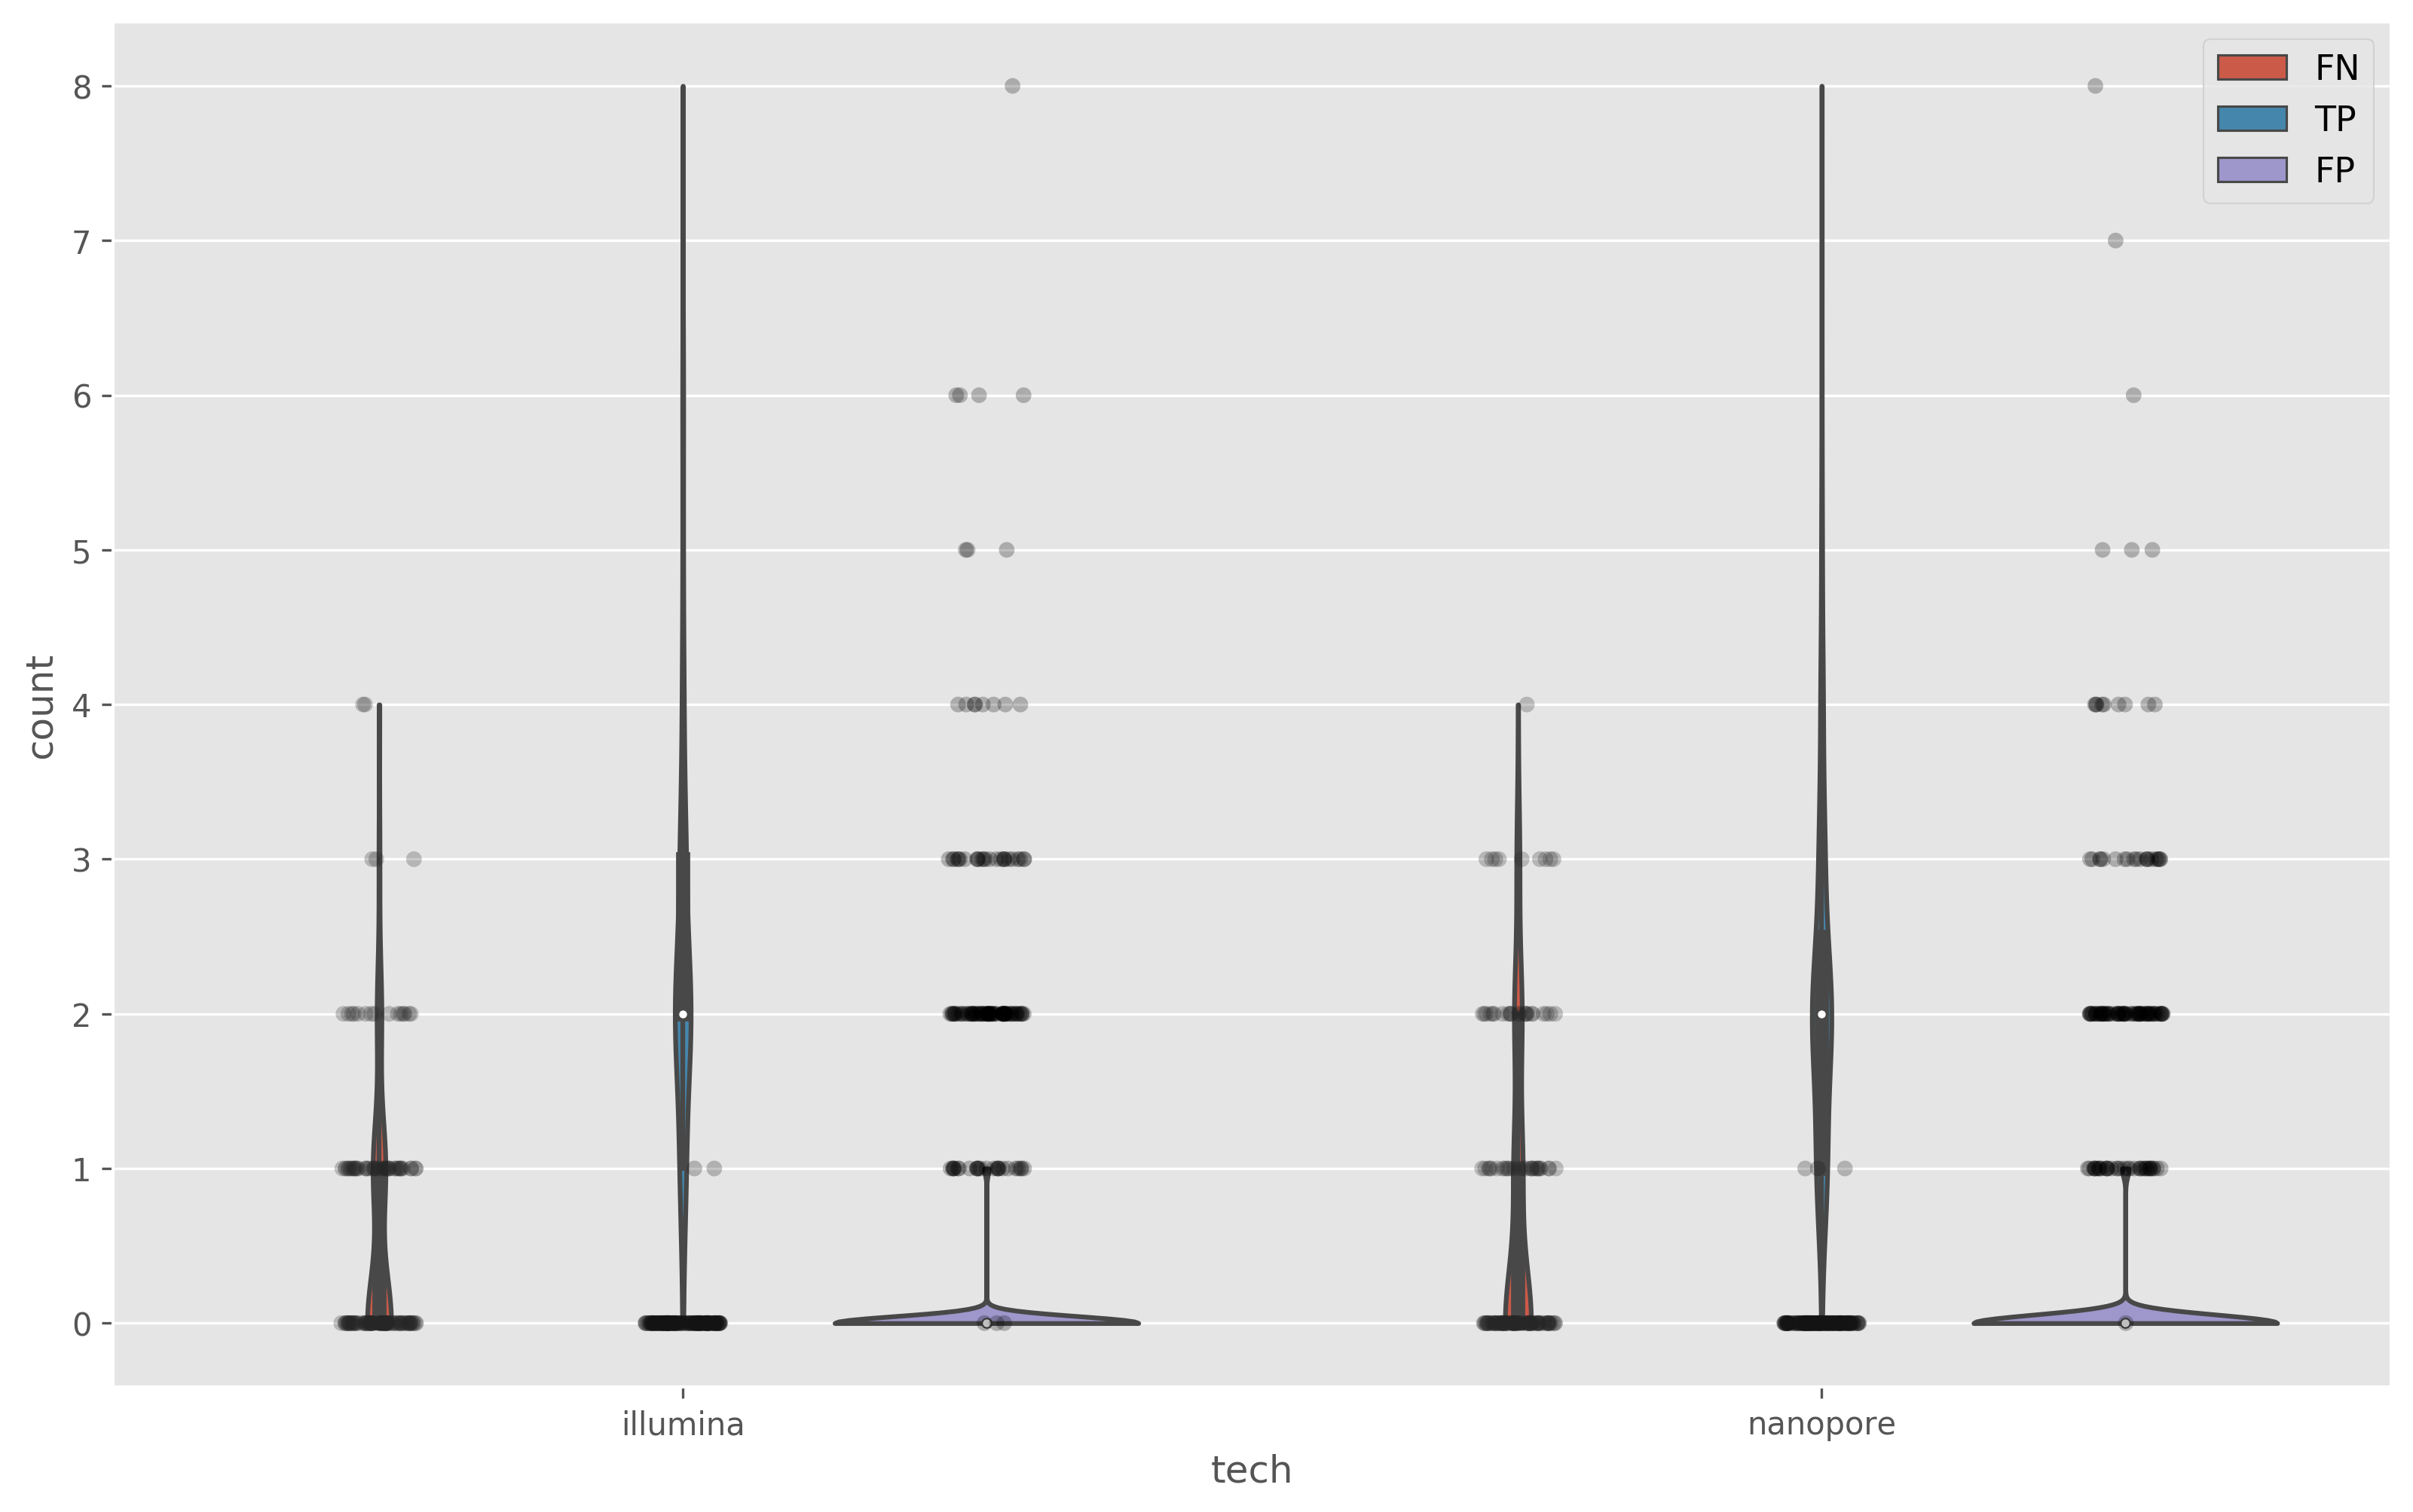

In [16]:
hue_order = ["FN", "TP", "FP"]
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
x = "tech"
y = "count"
hue = "classification"
sns.violinplot(data=counts, x=x, y=y, hue=hue, cut=0, hue_order=hue_order)
sns.stripplot(data=counts, x=x, y=y, hue=hue, dodge=True, jitter=True, color="black", alpha=0.25)

leghandles, leglabels = ax.get_legend_handles_labels()
ax.legend(leghandles[:-3], leglabels[:-3], loc="best", prop={"size": 11})

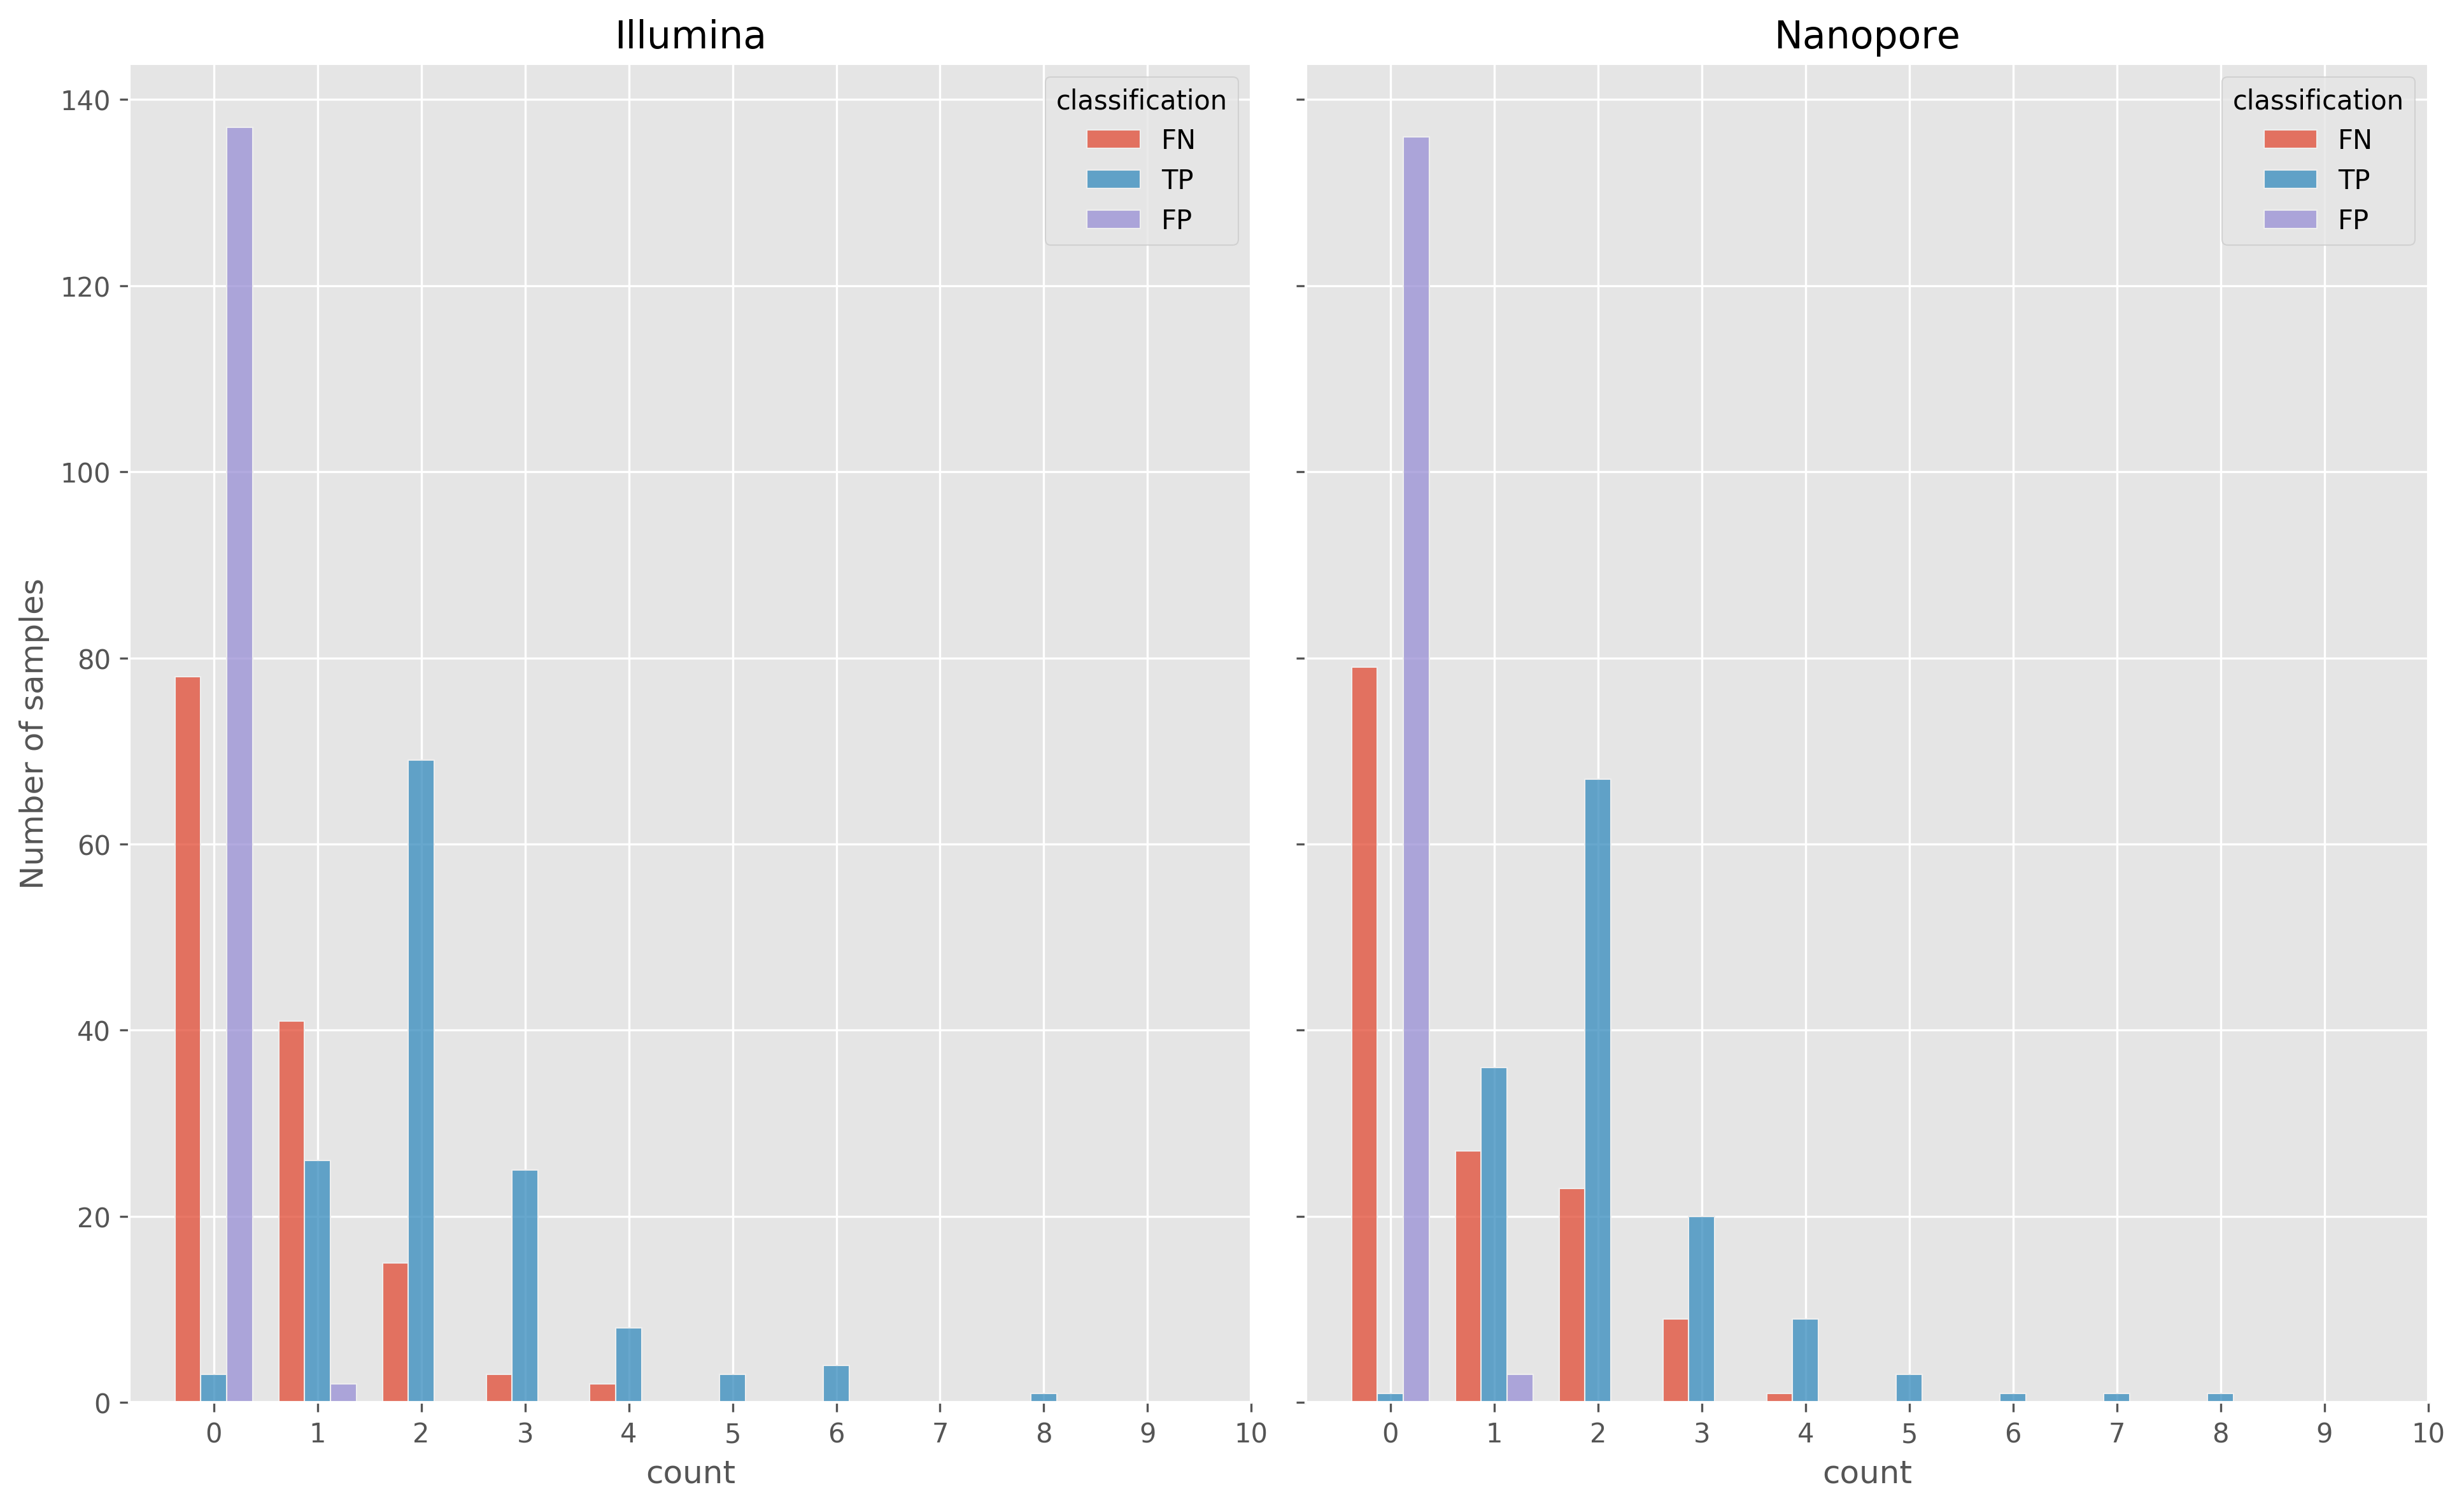

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI, sharey=True)
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    x = "count"
    hue = "classification"
    sns.histplot(
        data=counts.query("tech == @tech"), 
        x=x, 
        hue=hue, 
        hue_order=hue_order,
        ax=ax, 
        stat="count", 
        multiple="dodge", 
        discrete=True,
#         kde=True,
        shrink=0.75
    )
    ax.set_title(f"{tech.capitalize()}")
    ax.set_xticks(range(11))
    
axes.flatten()[0].set_ylabel("Number of samples")
plt.tight_layout()

In [18]:
counts.groupby(["tech", "classification"]).describe()

count                                             
                         count      mean       std  min  25%  50%  75%  max
tech     classification                                                    
illumina FN              139.0  0.633094  0.869315  0.0  0.0  0.0  1.0  4.0
         FP              139.0  0.014388  0.119517  0.0  0.0  0.0  0.0  1.0
         TP              139.0  2.287770  1.235024  0.0  2.0  2.0  3.0  8.0
nanopore FN              139.0  0.748201  1.000677  0.0  0.0  0.0  1.0  4.0
         FP              139.0  0.021583  0.145842  0.0  0.0  0.0  0.0  1.0
         TP              139.0  2.172662  1.191322  0.0  1.0  2.0  2.5  8.0

In [19]:
# columns = ["sample", "tech", "gene", "classification", "count"]

In [20]:
# exclude_indels = True
# data = []
# clf_tag = "VFR_RESULT"
# for p in Path("../../results/novel/").rglob("recall.vcf"):
#     sample = p.parts[-3]
#     tech = p.parts[-5]
#     for v in VCF(p):
#         if exclude_indels and is_indel(v):
#             continue
#         gene = v.CHROM
#         clf = v.format(clf_tag)[0]
#         if "FP" in clf:
#             clf = "FN"
#         if "TP" in clf:
#             clf = "TP"
#         data.append((sample, tech, gene, clf, 1, is_indel(v)))

# for p in Path("../../results/novel/").rglob("precision.vcf"):
#     sample = p.parts[-2]
#     tech = p.parts[-4]
#     for v in VCF(p):
#         if exclude_indels and is_indel(v):
#             continue
#         gene = v.CHROM
#         clf = v.format(clf_tag)[0]
#         if "FP" in clf:
#             clf = "FP"
#         if "TP" in clf:
#             clf="TP"
#         data.append((sample, tech, gene, clf, 1, is_indel(v)))

In [21]:
# df = pd.DataFrame(data, columns=columns)
df.sort_values("gene", inplace=True)

In [22]:
genes = df.drop(columns=["sample"]).groupby(["gene", "classification", "tech"]).sum().reset_index()
genes

,gene,classification,tech,count
0,ahpC,FN,illumina,2
1,ahpC,FN,nanopore,19
2,ahpC,FP,illumina,0
3,ahpC,FP,nanopore,0
4,ahpC,TP,illumina,34
...,...,...,...,...
73,rrs,FN,nanopore,10
74,rrs,FP,illumina,0
75,rrs,FP,nanopore,1
76,rrs,TP,illumina,13


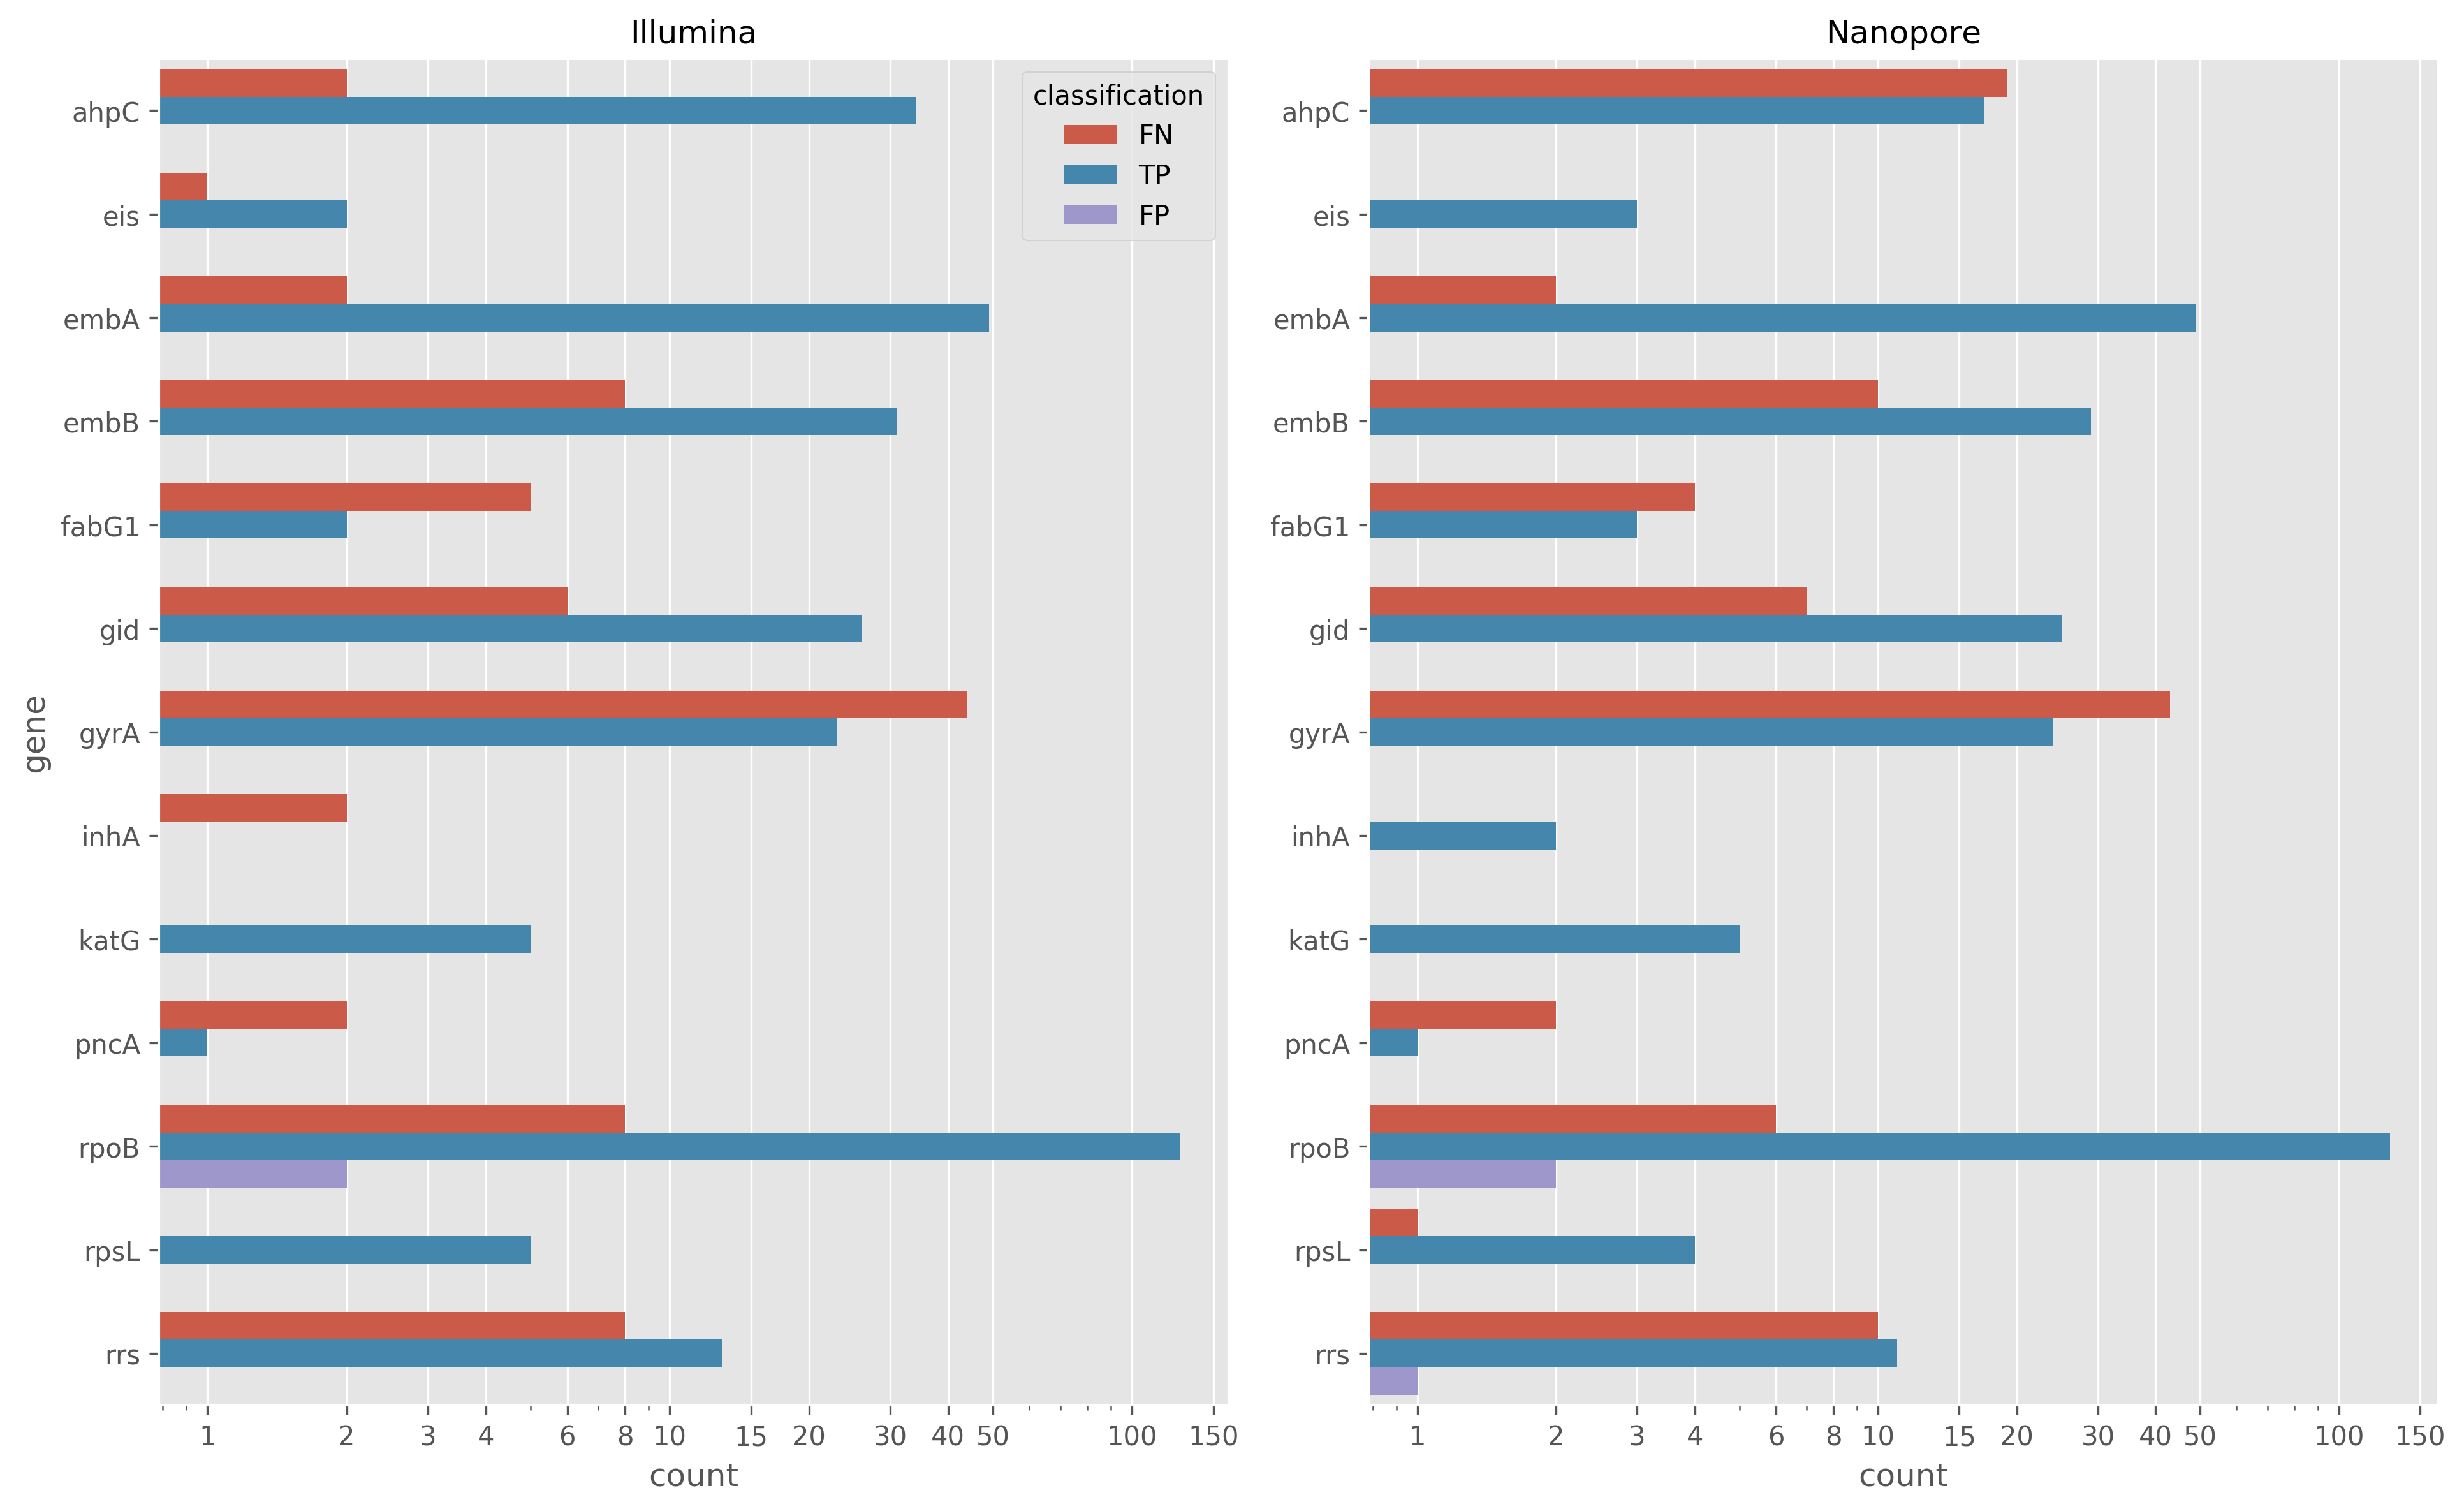

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.barplot(data=genes.query("tech==@tech"), hue="classification", x="count", y="gene", ax=ax, hue_order=hue_order)
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
    ax.set_xscale("log")
    labels = [1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 40, 50, 100, 150]
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

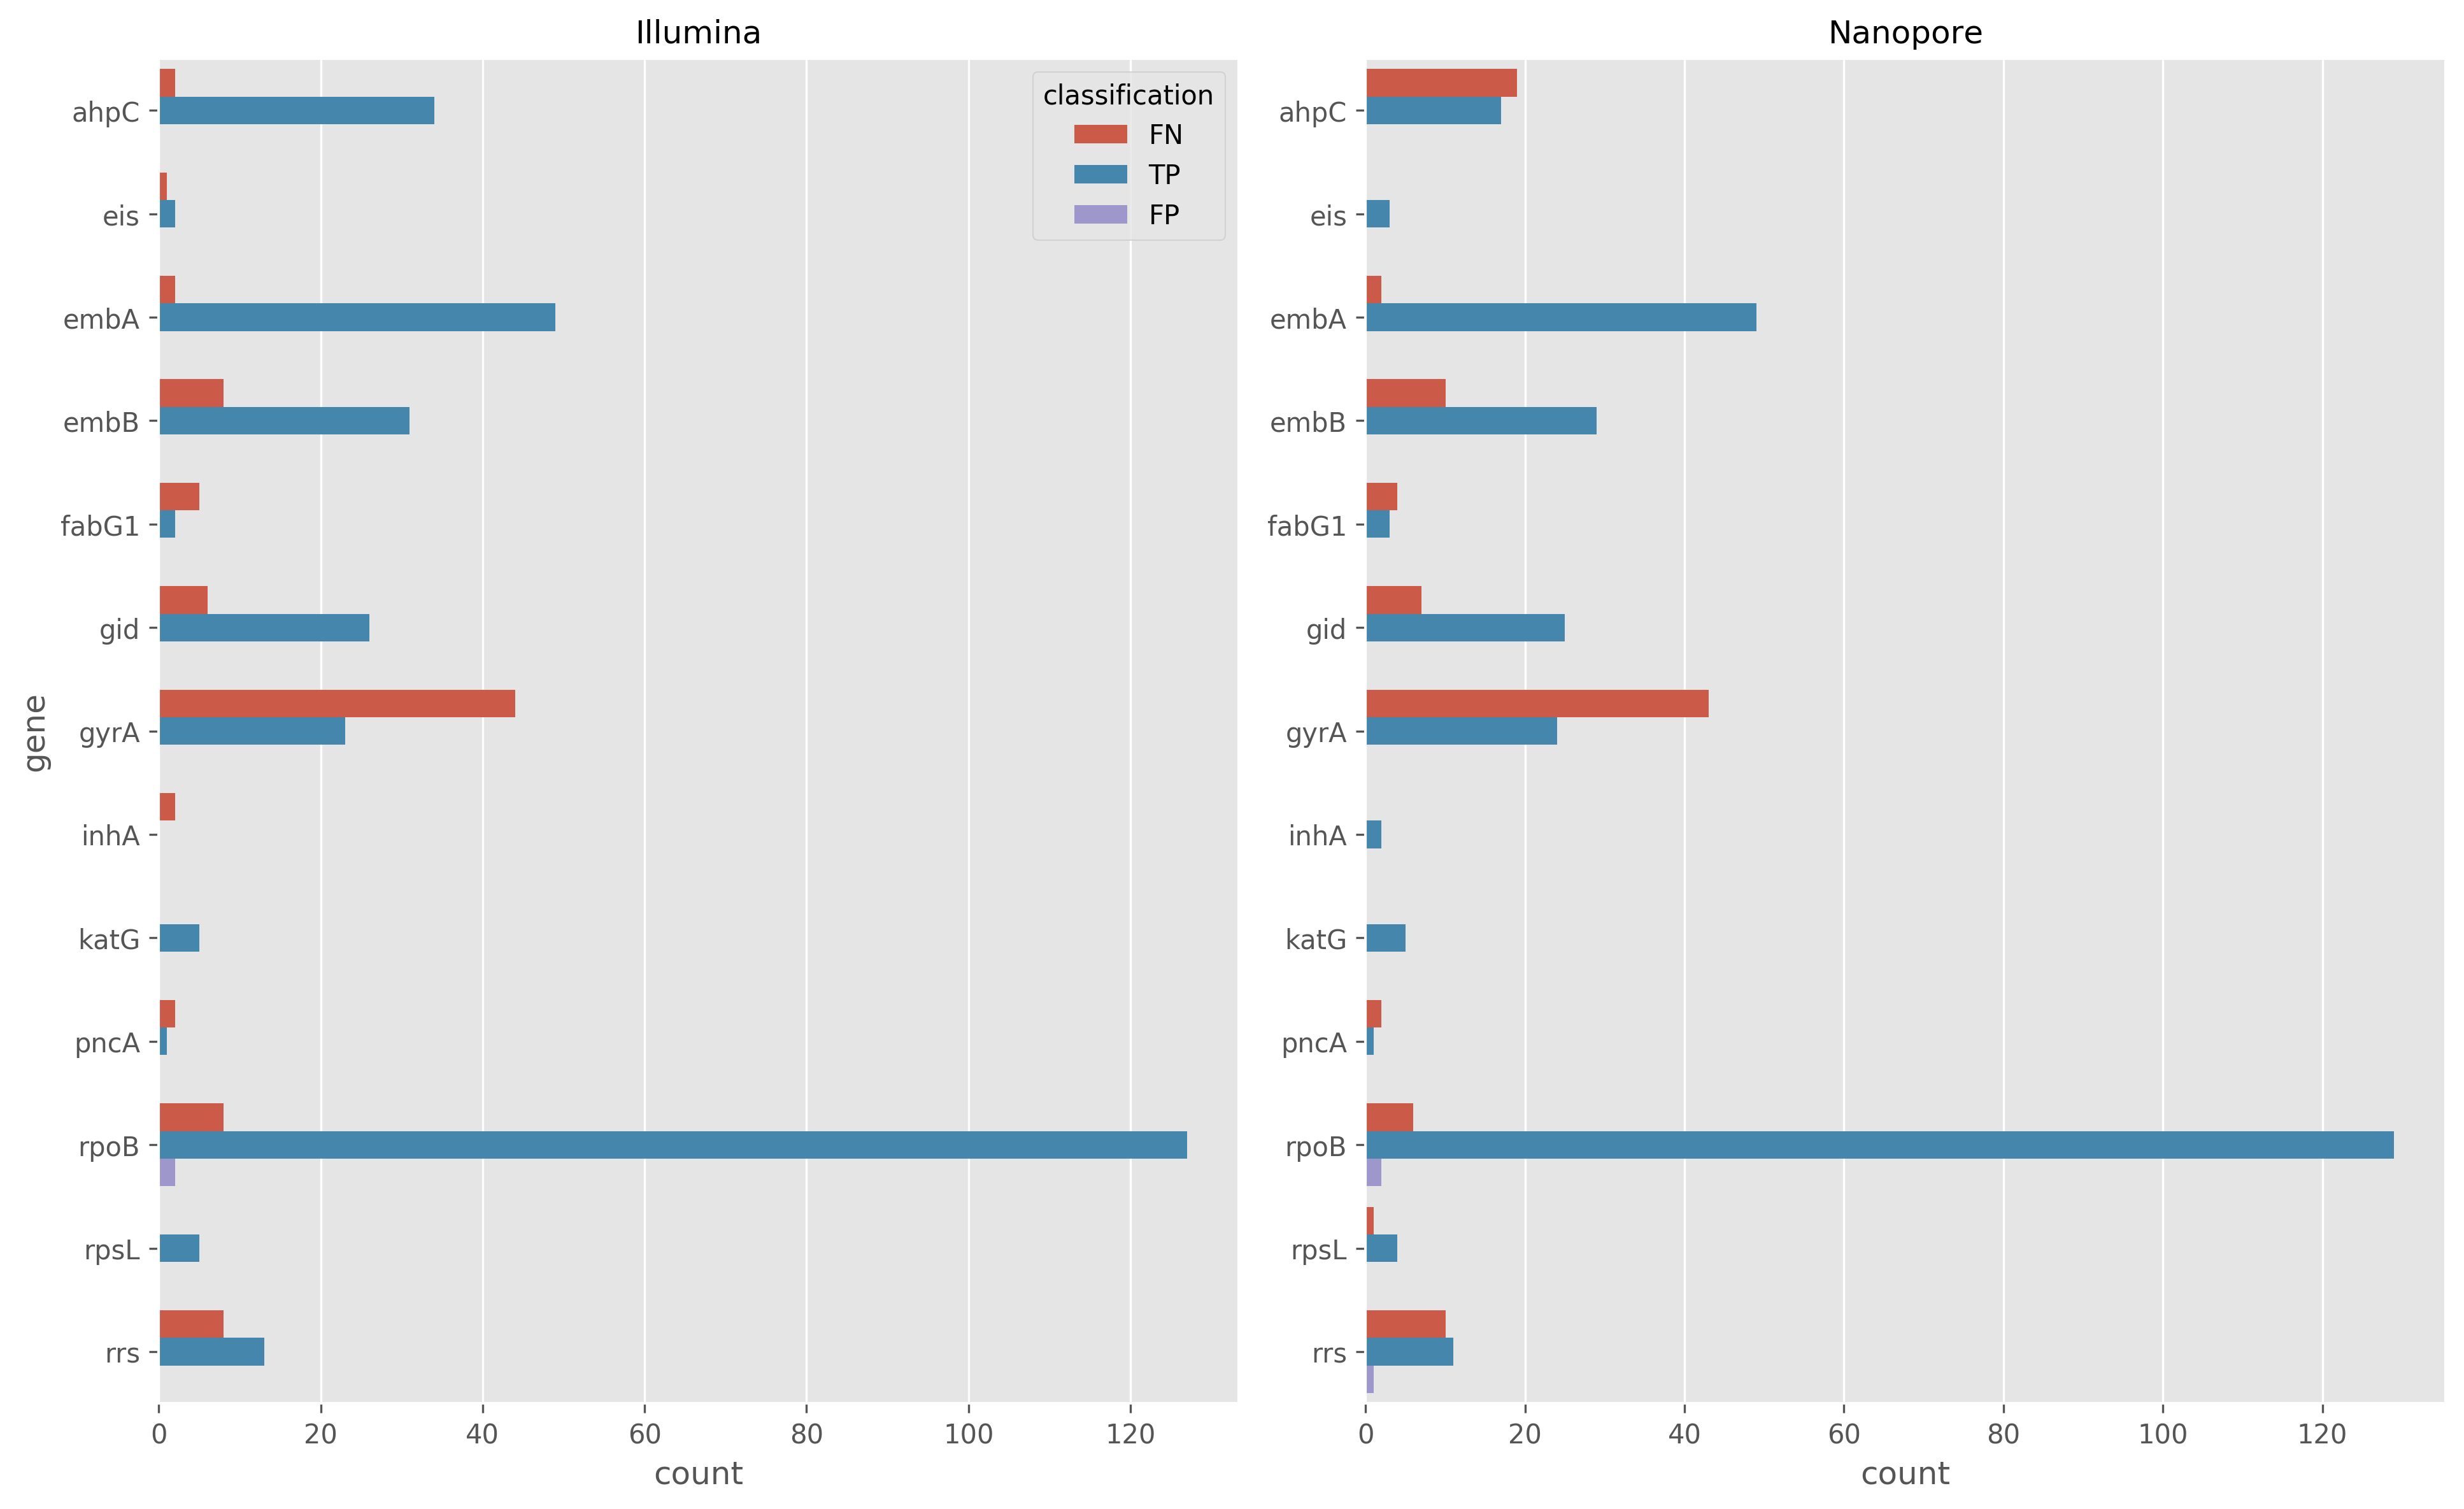

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.barplot(data=genes.query("tech==@tech"), hue="classification", x="count", y="gene", ax=ax, hue_order=hue_order)
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))

ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

In [25]:
def format_cell(cell):
    if isinstance(cell, list):
        if len(cell) == 2:
            return f"{cell[0]} ({cell[1]})" if cell[1] else f"{cell[0]}"
        else:
            return f"{cell[0]}"
    else:
        return cell
    
def recall(row):
    return int(row.TP) / (int(row.TP) + int(row.FN))

def precision(row):
    try:
        return int(row.TP) / (int(row.TP) + int(row.FP))
    except ZeroDivisionError:
        return None

In [26]:
tbl = defaultdict(dict)
for i, row in genes.iterrows():
    ix = (row["gene"], row["tech"])
    try:
        tbl[ix][row["classification"]][0] += row["count"]
#         tbl[ix][row["classification"]][1] += int(row["is_indel"])
    except KeyError:
        tbl[ix][row["classification"]] = [row["count"]]
        
tbl = pd.DataFrame(tbl).T.fillna(0).sort_index().applymap(format_cell)
tbl = tbl.reset_index().rename(columns={"level_0": "Gene", "level_1": "Technology"})
tbl["Technology"] = [s.capitalize() for s in tbl["Technology"]]
tbl["Recall"] = tbl.apply(lambda row: recall(row), axis=1)
tbl["Precision"] = tbl.apply(lambda row: precision(row), axis=1)
tex = tbl.to_latex(float_format="%.3f", index=False, na_rep="-")
print(tex)

\begin{tabular}{lllllrr}
\toprule
 Gene & Technology & FN & FP &  TP &  Recall &  Precision \\
\midrule
 ahpC &   Illumina &  2 &  0 &  34 &   0.944 &      1.000 \\
 ahpC &   Nanopore & 19 &  0 &  17 &   0.472 &      1.000 \\
  eis &   Illumina &  1 &  0 &   2 &   0.667 &      1.000 \\
  eis &   Nanopore &  0 &  0 &   3 &   1.000 &      1.000 \\
 embA &   Illumina &  2 &  0 &  49 &   0.961 &      1.000 \\
 embA &   Nanopore &  2 &  0 &  49 &   0.961 &      1.000 \\
 embB &   Illumina &  8 &  0 &  31 &   0.795 &      1.000 \\
 embB &   Nanopore & 10 &  0 &  29 &   0.744 &      1.000 \\
fabG1 &   Illumina &  5 &  0 &   2 &   0.286 &      1.000 \\
fabG1 &   Nanopore &  4 &  0 &   3 &   0.429 &      1.000 \\
  gid &   Illumina &  6 &  0 &  26 &   0.812 &      1.000 \\
  gid &   Nanopore &  7 &  0 &  25 &   0.781 &      1.000 \\
 gyrA &   Illumina & 44 &  0 &  23 &   0.343 &      1.000 \\
 gyrA &   Nanopore & 43 &  0 &  24 &   0.358 &      1.000 \\
 inhA &   Illumina &  2 &  0 &   0 &   0.0

In [27]:
df.query("gene=='embB' and classification == 'FN' and count != 0")

,gene,classification,count,sample,tech
1,embB,FN,1,R28581,nanopore
1,embB,FN,1,R29598,nanopore
0,embB,FN,1,mada_140,illumina
1,embB,FN,1,mada_118,illumina
1,embB,FN,1,mada_1-18,nanopore
1,embB,FN,1,mada_1-44,nanopore
1,embB,FN,1,mada_1-43,nanopore
1,embB,FN,1,mada_118,nanopore
1,embB,FN,1,mada_1-40,nanopore
2,embB,FN,1,mada_1-47,nanopore


In [28]:
counts.query("sample=='mada_1-10'")

,sample,tech,classification,count
354,mada_1-10,illumina,FN,3
355,mada_1-10,illumina,FP,0
356,mada_1-10,illumina,TP,6
357,mada_1-10,nanopore,FN,1
358,mada_1-10,nanopore,FP,0
359,mada_1-10,nanopore,TP,8


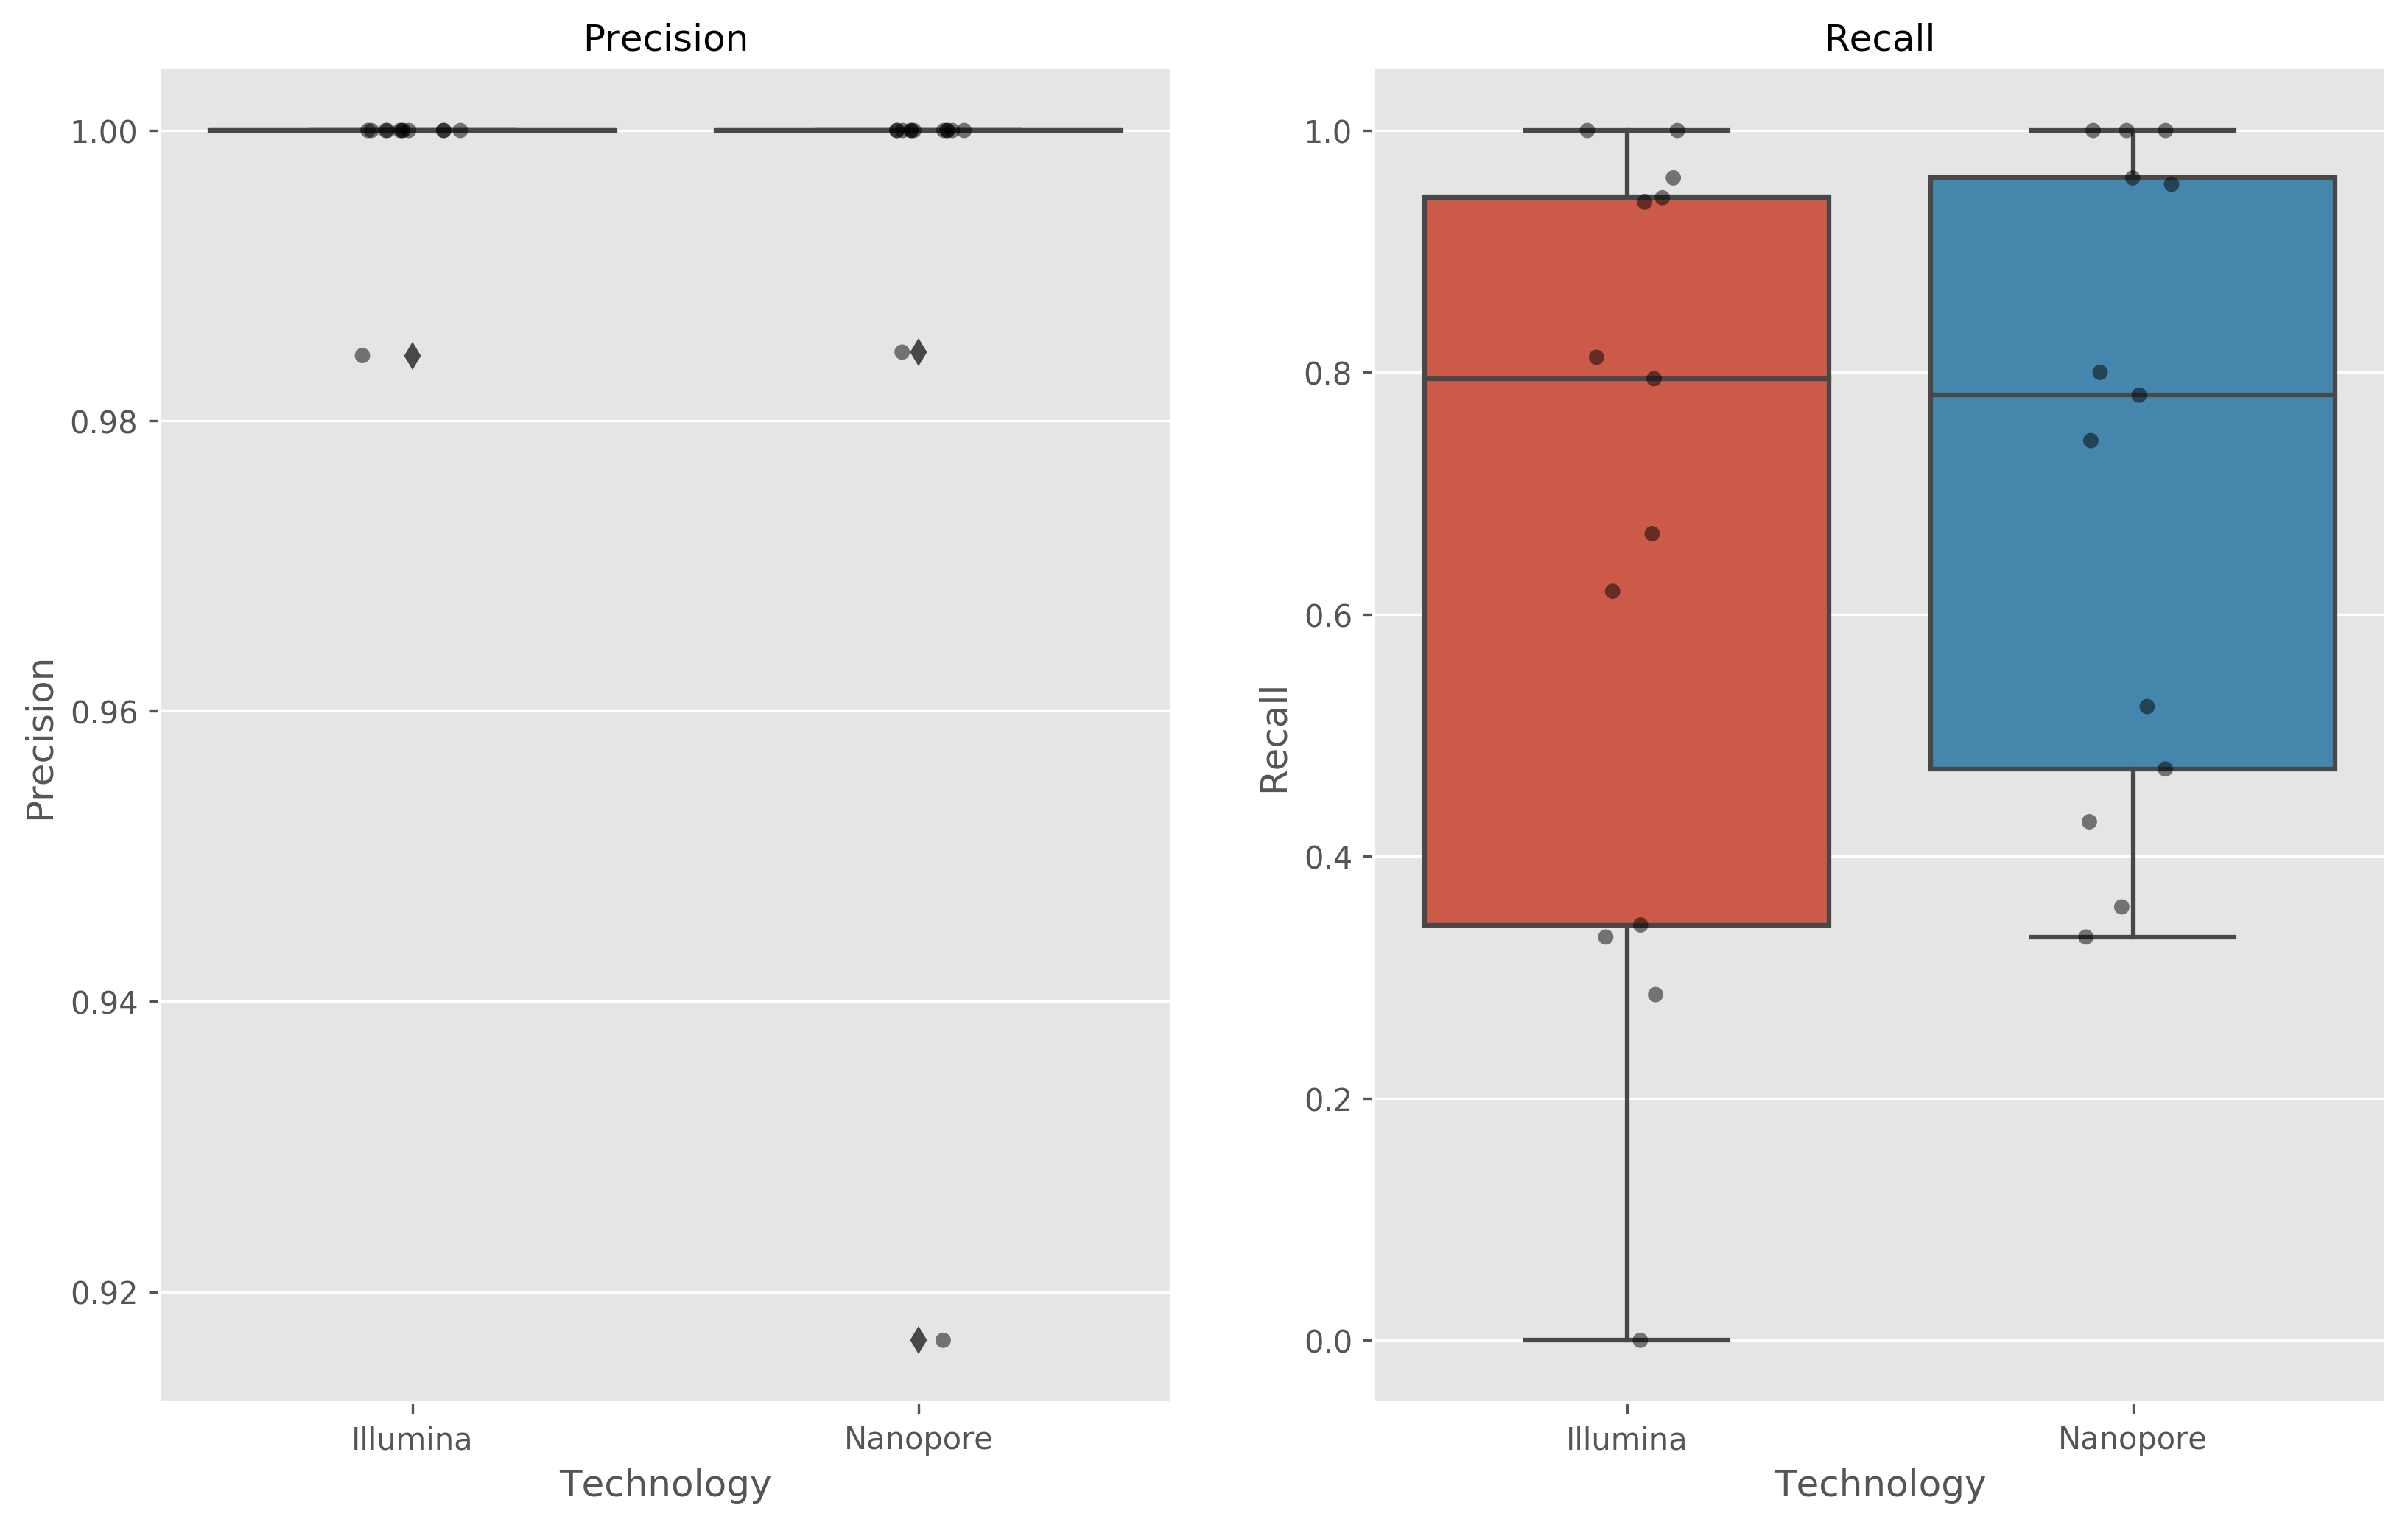

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, metric in zip(axes.flatten(), ["Precision", "Recall"]):
    sns.boxplot(data=tbl, x="Technology", y=metric, ax=ax, )
    sns.stripplot(data=tbl, x="Technology", y=metric, ax=ax, color="black", alpha=0.5)
    ax.set_title(metric.capitalize(), fontdict=dict(fontsize=12))

AttributeError: 'str' object has no attribute 'query'

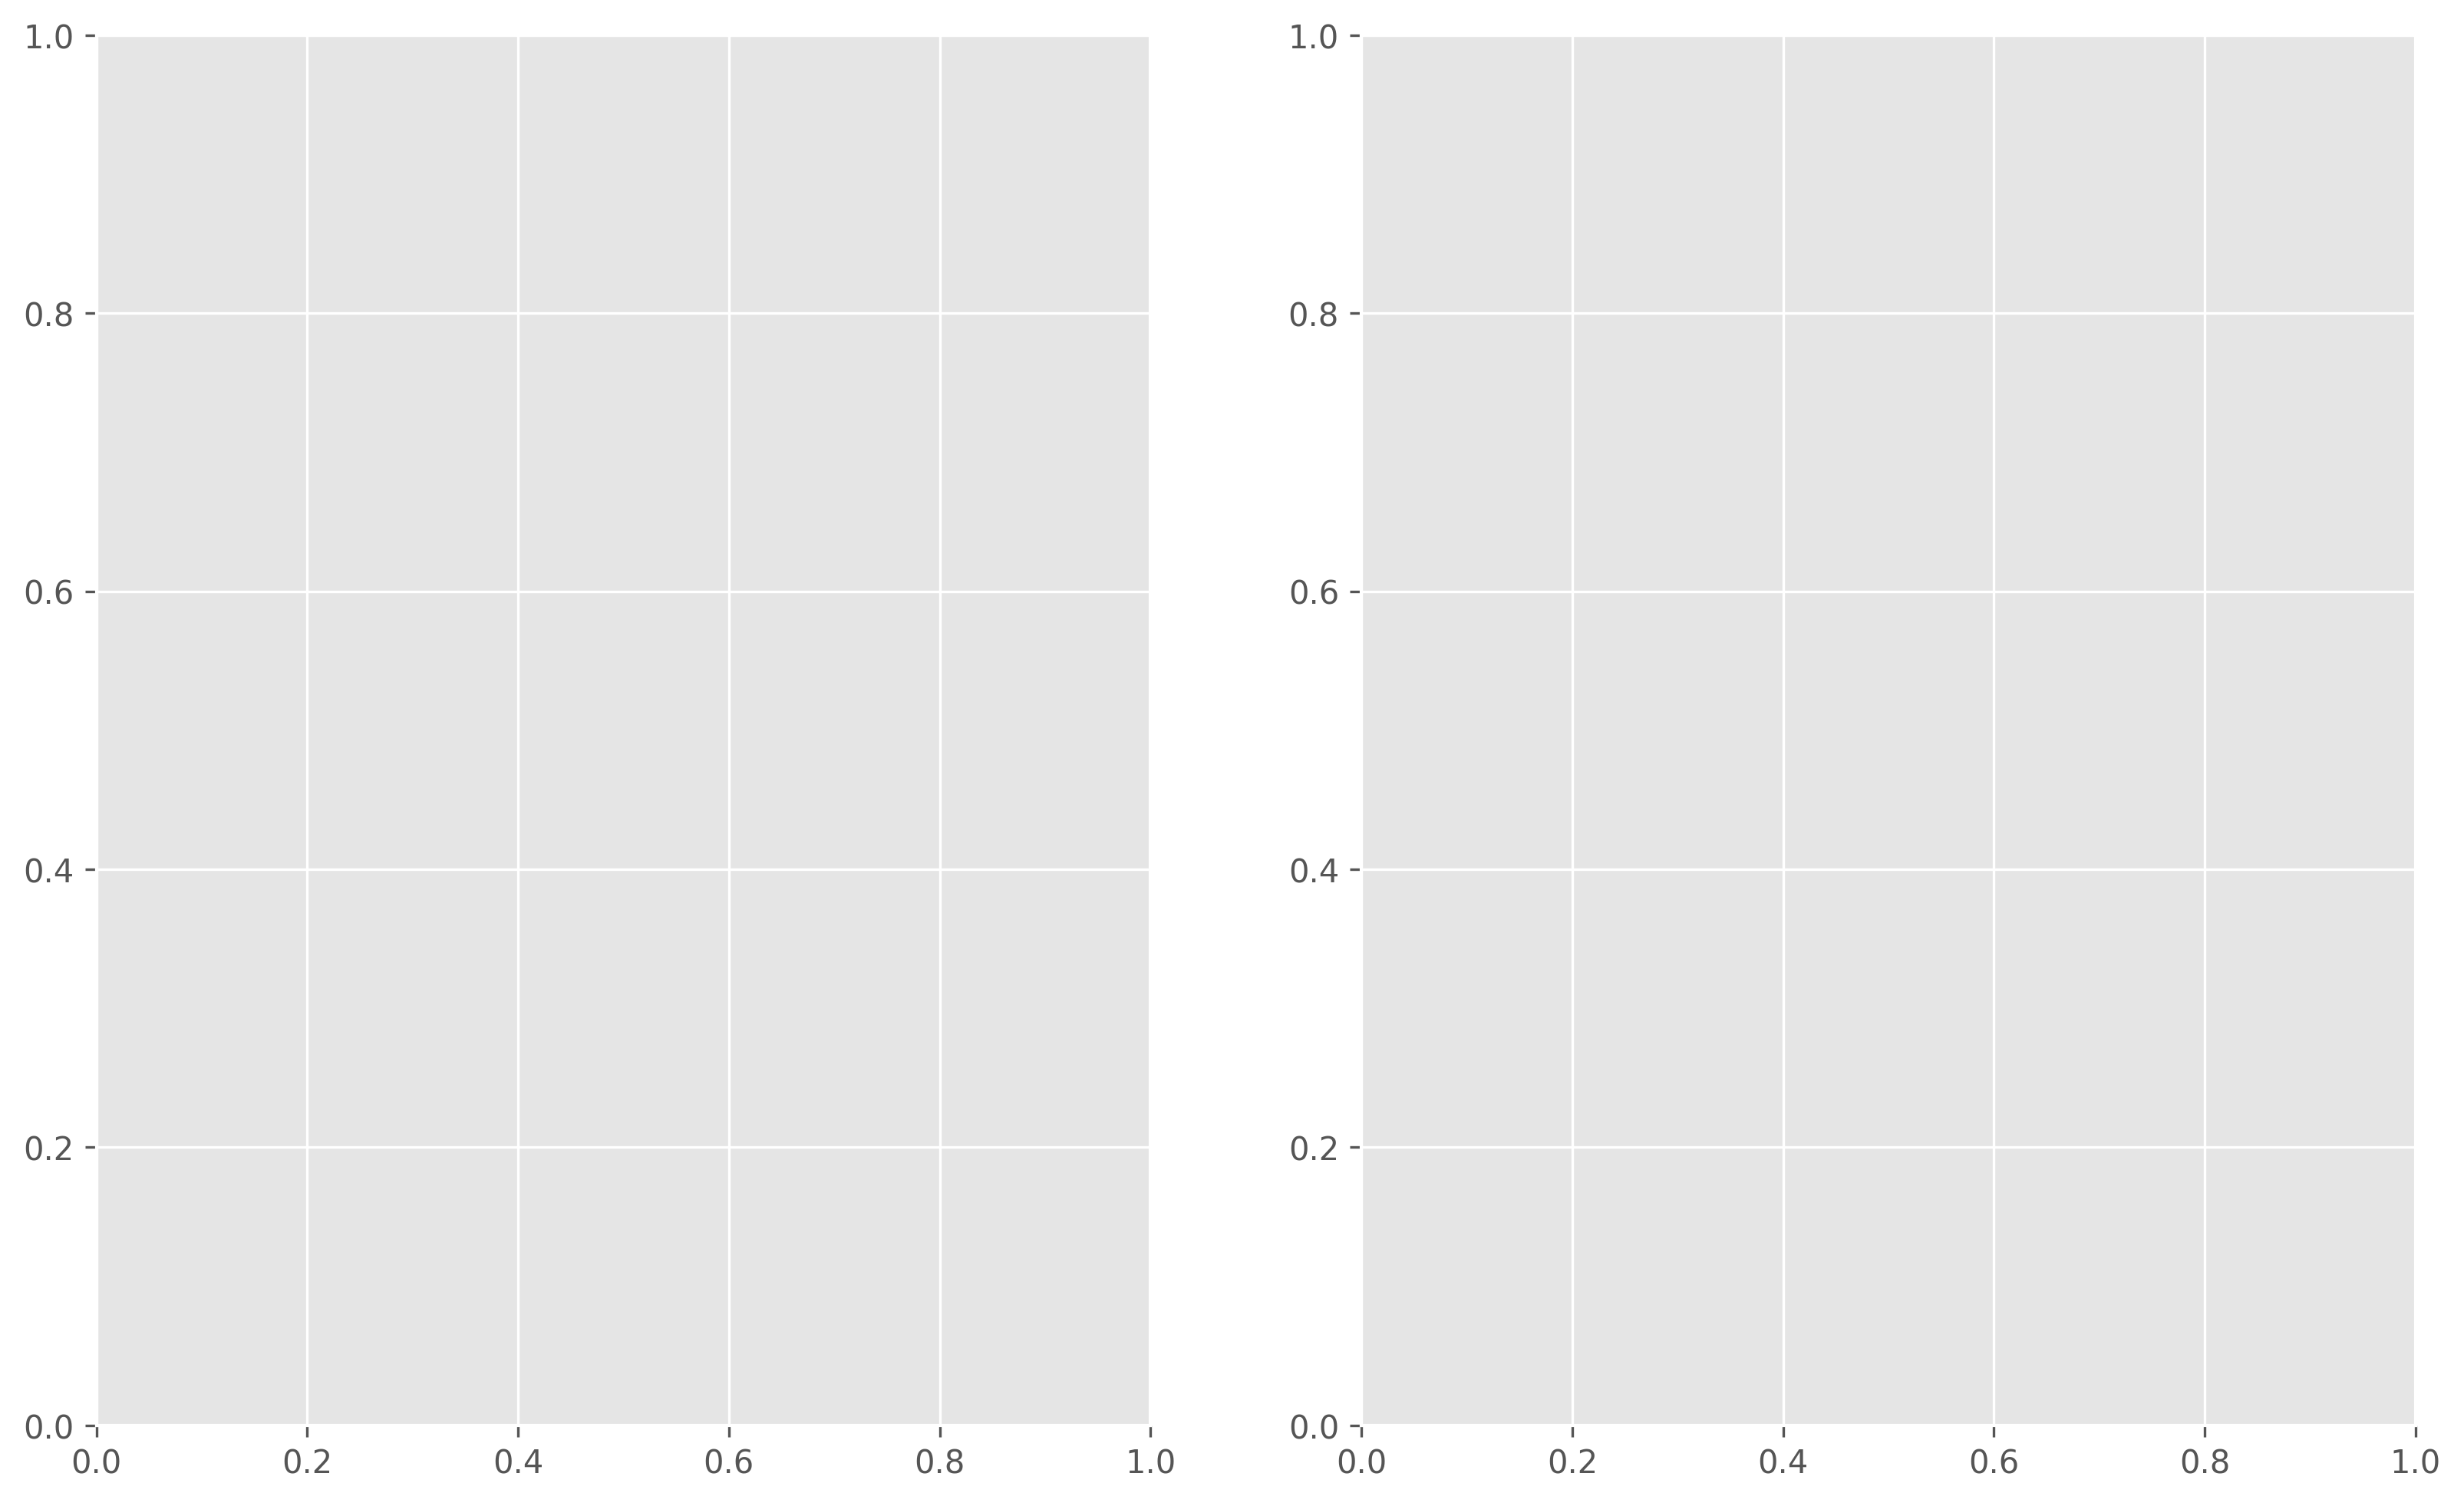

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=FIGSIZE, dpi=DPI)
hue_order = ["FN", "TP", "FP"]
for ax, tech in zip(axes.flatten(), ["illumina", "nanopore"]):
    sns.stripplot(data=g.query("tech==@tech"), dodge=True,hue="classification", y="gene", ax=ax, hue_order=hue_order, x="count")
    ax.set_title(tech.capitalize(), fontdict=dict(fontsize=12))
ax.set_ylabel("")
ax.get_legend().remove()
plt.tight_layout()

In [ ]:
df.groupby(["tech"])["is_indel"].describe()